In [305]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, cpw_capacitance_inductance, get_equivalent_lc, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import *
from qucat import Network,L,J,C,R
from modeling.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck


In [306]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200)
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [307]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.9

nb_qubits = 4
rr_freq_target = np.array([7e9, 7.1e9, 7.2e9, 7.3e9])
c_sigma_unloaded = 90e-15
target_parameters = {
    "chi": 0.5e6,
    "qubit_frequency": 4e9,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma_unloaded
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [308]:
def minimize_for_lj(x):
    EC = e_charge**2/c_sigma_unloaded/2/planck_h
    Ej = get_Ej_from_Lj(x[0]*1e-9)
    qubit_frequency = Transmon(EC =EC, EJ = Ej, ng = 0.5, ncut = 31)
    return abs(qubit_frequency.E01() - target_parameters["qubit_frequency"])

def minimize_for_chi(x, c_r = None, l_r = None):
    cir = Network([
        C(0,1,c_sigma_unloaded), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r  - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2,x[0]*1e-15), # coupling capacitor
    ])
    return abs(cir.kerr(Lj = Lj)[0,1] - target_parameters["chi"])

In [309]:
Lj = fsolve(minimize_for_lj, 10)[0]*1e-9
Ic = get_Ic_from_Lj(Lj)
EC = e_charge**2/c_sigma_unloaded/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

In [310]:
cqrs = []
for i in range(nb_qubits):
    cqrs += [fsolve(minimize_for_chi, 3, args =(c_r[i], l_r[i]))[0]*1e-15]
    
ratio = Ej/EC
transmon = Transmon(EJ=Ej,
                              EC=EC,
                              ng=0.3,
                              ncut=31)
qubit_01 = transmon.E01()
qubit_anharm = transmon.anharmonicity()
cqrs

[4.957749517694341e-15,
 5.0383915904186e-15,
 5.115722117488911e-15,
 5.189919234938921e-15]

Energy dispersion is  1.1550090251922607e-05 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

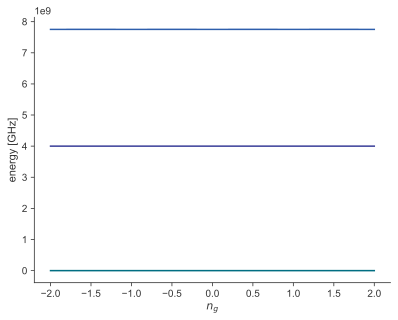

In [311]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej, EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [312]:
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma_unloaded), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Lj)

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.12 GHz |          0Hz |      204 MHz |
            1 |        7 GHz |          0Hz |       307 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      204 MHz |              |
            1 |      500 kHz |       307 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.11 GHz |          0Hz |      203 MHz |
            1 |     7.11 GHz |          0Hz |       307 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      203 MHz |              |
            1 |      500 kHz |       307 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.11 GHz |          0Hz |      203 MHz |
            1 |     7.21 GHz |          0Hz |       307 Hz |

Kerr coefficients (diagonal = Kerr, off-diag

In [313]:
cqrs

[4.957749517694341e-15,
 5.0383915904186e-15,
 5.115722117488911e-15,
 5.189919234938921e-15]

In [314]:
kappa_target = 1e6
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    return abs(k - kappa_target)

In [315]:
cks = []
for i in range(nb_qubits):
    cks += [fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15]
cks

[8.099603607934524e-15,
 7.929089173291576e-15,
 7.764474724355119e-15,
 7.605478360638873e-15]

In [316]:
resonator_waveguide_capacitance = c_r - cqr_to_ground(np.array(cqrs)) - ck_to_ground(np.array(cks)) 
rr_cap_ratio = resonator_waveguide_capacitance / c_r
resonator_waveguide_capacitance = resonator_waveguide_capacitance - np.array(cqrs) - np.array(cks)
resonator_waveguide_inductance = l_r * rr_cap_ratio
c_l, l_l = cpw_cl_ll(a, b, ep_r)
resonator_waveguide_lengths = np.pi * np.sqrt((resonator_waveguide_capacitance * resonator_waveguide_inductance) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00754776, 0.00742847, 0.00731266, 0.00720001])

In [317]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_finger_control = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_finger_control(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Effective C sigma for qubit {i}: {c_sigma_given_coupler_width(coupler_width):.5} fF")

Coupler width for qubit 0: 151.23 um
Finger control for qubit 0: 2.0865
Effective C sigma for qubit 0: 9.0076e-14 fF
Coupler width for qubit 1: 154.51 um
Finger control for qubit 1: 2.0687
Effective C sigma for qubit 1: 9.0092e-14 fF
Coupler width for qubit 2: 157.65 um
Finger control for qubit 2: 2.0513
Effective C sigma for qubit 2: 9.0109e-14 fF
Coupler width for qubit 3: 160.64 um
Finger control for qubit 3: 2.0344
Effective C sigma for qubit 3: 9.0126e-14 fF


In [318]:
fl_traits = pd.read_csv("single_clockmons_readout_structure.csv").values[0][1:]
tee_size = pd.read_csv("single_clockmons_readout_structure.csv").values[1][1:]
res_length = pd.read_csv("single_clockmons_readout_structure.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = []
transmission_line_tee_points += [fl_traits[0] + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[3] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[4] + (a+2*b)/2*1e6]

In [319]:
resonator_capacitance = resonator_waveguide_capacitance + ck_to_ground(np.array(cks)) + cqr_to_ground(np.array(cqrs))
options = {
    "qubit_c": [c_sigma_unloaded]*4,
    "qubit_l": [Lj]*4,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [7.29, 7.31],
    "n_points": 1001,
    "type": "simple"
}
resonator_capacitance
# array([2.76817932e-13, 2.72824803e-13, 2.68942504e-13, 2.65166475e-13])


array([2.76393924e-13, 2.72407018e-13, 2.68530767e-13, 2.64760622e-13])

2-Port Network: '',  7.29-7.31 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


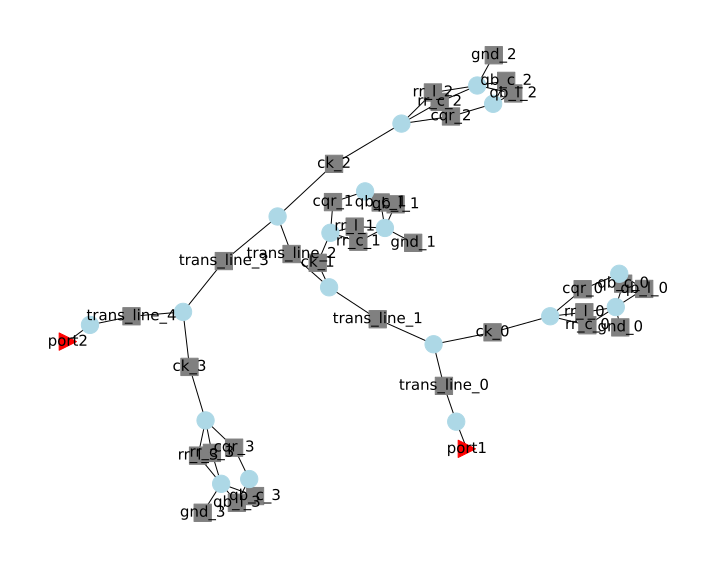

In [320]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

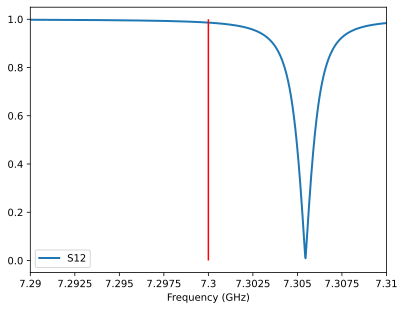

In [321]:
ntw.plot_s_mag(m=0, n=1, lw=2)
import matplotlib.pyplot as plt
plt.vlines(x = 1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi, ymin = 0, ymax = 1, colors="red")
# rr_freq = ntw.f[np.argmin(np.abs(ntw.s[:, 0, 1]))]
# plt.hlines(0.5, xmin = rr_freq - 1e6/2, xmax = rr_freq +  1e6/2)